# XGBoost

## 0. 前準備

In [12]:
# セル直下に直接図示.
%matplotlib inline

# グラフおよびデザインに関するモジュール.
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

# air passenger データセット.
from sandbox.datasets import air_passengers

from sandbox.features.features import get_features                # 特徴量生成モジュール.
from sandbox.model_selection import (
    train_test_split,                                             # データ分割 (scikit-learn と同じ)
    GroupTimeSeriesSplit,                                         # 時系列用CV spliter
    XGBoostOptunaSearchCV                                         # CVを伴うXGBoost用ハイパーパラメータ探索
)
from sandbox.ensemble.boost import XGBoostRegressor               # XGBoost回帰器
from sandbox.metrics.score import mean_absolute_percentage_error  # MAPE(scikit-learn と同じ)

sns.set()

## 1. テストデータの準備

### 1.1. AirPassengers データ Overview

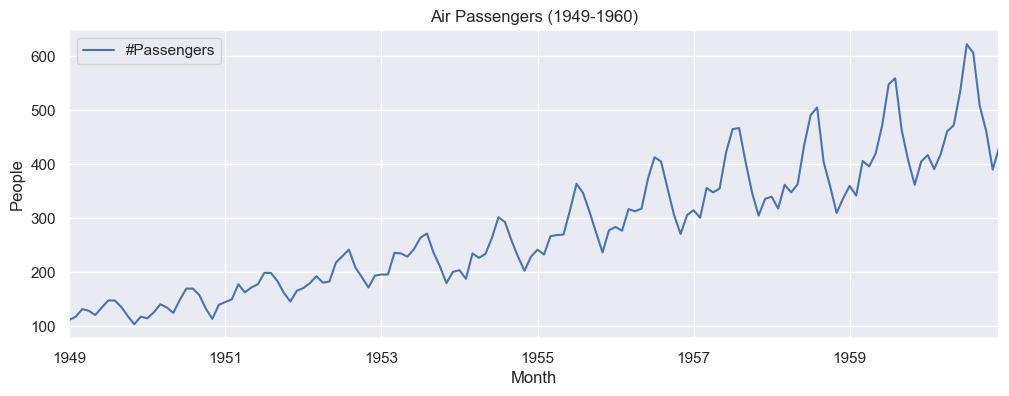

In [13]:
data = air_passengers.load().data

fig, ax = plt.subplots(figsize=(12, 4))
data.plot(y="#Passengers", ax=ax)
ax.set_ylabel("People")
ax.set_title("Air Passengers (1949-1960)")
plt.show()

In [14]:
data.head(10)

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
1949-06-01,135.0
1949-07-01,148.0
1949-08-01,148.0
1949-09-01,136.0


### 1.2. 特徴量生成

　日付に関する特徴量を作成.

In [15]:
# indexに設定されているMonthをもとに特徴量を生成するためindexから列に変換.
data.reset_index(inplace=True)

# 特徴量の生成.
# column_valuesで指定した列に対して特徴量を生成する.
# グループ単位で処理する場合にはcolumn_idでグループを区切る列名を指定する. 今回はないのでNone.
# window, shift系の処理をする場合に列順がある場合にはsort_valuesで指定する.
# func_param_list に処理する特徴量メソッドを設定する.
column_values = ["Month"]
column_id = None
sort_values = ["Month"]
func_params_list = [
    {"func_name": "month", "func_params": None},
    {"func_name": "year", "func_params": None},
]

data_ts = get_features(
    data,
    column_values=column_values,
    column_id=column_id,
    sort_values=sort_values,
    func_params_list=func_params_list
)

data_ts.head(10)

,index,Month,#Passengers,Month__month,Month__year
0,0,1949-01-01,112.0,1,1949
1,1,1949-02-01,118.0,2,1949
2,2,1949-03-01,132.0,3,1949
3,3,1949-04-01,129.0,4,1949
4,4,1949-05-01,121.0,5,1949
5,5,1949-06-01,135.0,6,1949
6,6,1949-07-01,148.0,7,1949
7,7,1949-08-01,148.0,8,1949
8,8,1949-09-01,136.0,9,1949
9,9,1949-10-01,119.0,10,1949


　lag系, window関数系の特徴量を生成.

In [16]:
# 予測期間は先12ヶ月とすれば, lag=12以上であれば移動平均やラグについて過去データから生成されたものとして取り扱える.
# (予測期間がNULLでも特徴量として有効)
column_values = ["#Passengers"]
column_id = None
sort_values = ["Month"]
func_params_list = [
    {"func_name": "lag", "func_params": [{"lag": 12},]},
    {"func_name": "rolling", "func_params": [
        {"lag": 12, "window": 6, "stats": ["mean",]},
        {"lag": 12, "window": 12, "stats": ["mean",]},
        {"lag": 12, "window": 18, "stats": ["mean",]},
        {"lag": 12, "window": 24, "stats": ["mean",]},
    ]},
]

data_ts_shifting = get_features(
    data_ts,
    column_values=column_values,
    column_id=column_id,
    sort_values=sort_values,
    func_params_list=func_params_list
)

data_ts_shifting.iloc[20:30]

,level_0,index,Month,#Passengers,Month__month,Month__year,#Passengers__lag_lag_12,#Passengers__rolling_mean_lag_12_window_6,#Passengers__rolling_mean_lag_12_window_12,#Passengers__rolling_mean_lag_12_window_18,#Passengers__rolling_mean_lag_12_window_24
20,20,20,1950-09-01,158.0,9,1950,136.0,136.166667,NaN,NaN,NaN
21,21,21,1950-10-01,133.0,10,1950,119.0,134.500000,NaN,NaN,NaN
22,22,22,1950-11-01,114.0,11,1950,104.0,131.666667,NaN,NaN,NaN
23,23,23,1950-12-01,140.0,12,1950,118.0,128.833333,126.666667,NaN,NaN
24,24,24,1951-01-01,145.0,1,1951,115.0,123.333333,126.916667,NaN,NaN
25,25,25,1951-02-01,150.0,2,1951,126.0,119.666667,127.583333,NaN,NaN
26,26,26,1951-03-01,178.0,3,1951,141.0,120.500000,128.333333,NaN,NaN
27,27,27,1951-04-01,163.0,4,1951,135.0,123.166667,128.833333,NaN,NaN
28,28,28,1951-05-01,172.0,5,1951,125.0,126.666667,129.166667,NaN,NaN
29,29,29,1951-06-01,178.0,6,1951,149.0,131.833333,130.333333,128.388889,NaN


　test/trainデータに分割するための後処理を実施.

In [17]:
# 不要なカラムを削除する.
# level_0, index は get_featureを実行することで付与されたもので元々あったindex番号.
data_ts_shifting.set_index(["Month"], drop=True, inplace=True)
data_ts_shifting.drop(columns=["level_0", "index"], inplace=True)

# train/testデータに分割する.
data_train, data_test = train_test_split(data_ts_shifting, test_size=12, shuffle=False)

X_name = data_train.columns.to_list()
X_name.remove("#Passengers")
y_name = ["#Passengers"]

X_train, y_train = data_train[X_name], data_train[y_name]
X_test, y_test = data_test[X_name], data_test[y_name]

## 2. XGBoost回帰器の使い方

### 2.1. 理論

#### XGBoost における損失関数

$\mathcal{D} = \{(\mathbf{x}_i, y_i)\} \ \ (|\mathcal{D}| = n, \mathbf{x}_i \in \mathbb{R}^m, y_i \in \mathbb{R})$

$K$ 個の弱学習器ツリーを用いて予測値を以下のようにして計算することとする.

$$
\begin{align*}
    \hat{y}_i = \phi(\mathbf{x}_i) = \sum_{k=1}^{K}{f_k(\mathbf{x}_i)}, \quad f_k \in \mathcal{F}
\end{align*}
$$

$\mathcal{F} = \{ f(\mathbf{x}) = w_{q(\mathbf{x})} \} \ \ (q: \mathbb{R}^m \rightarrow T, w \in \mathbb{R}^T)$ となる木集合. $w$ は葉ノードの重み付け値を示す.

:::{figure-md} xgboost-obj

<img src="../images/xgboost-obj.png" alt="xgboost-obj" class="bg-primary mb-1" width="600px">

$f_k(\mathbf{x}_i) = w_{q(x)}$ の関係性

:::

$f$ は決定木の構造が変わるたびに値が動くので, それぞれの学習器の決定木の構造が予測にフィットするように学習させていくのが目的.  
決定木の構造が変数, つまり $f$ が変数である.

$f$ を動かして $\hat{y}_i$ と $y_i$ の損失 (誤差) を最小化すれば良いが, そうすると決定木の深さが大きくなって損失が減少していく戦略をとりうる. そうするとインプットしたデータに異常に適合したモデルとなってしまい, そのモデルを用いて予測してもかえって精度が悪化しうる (汎化性能の減少).  
　ゆえに理想的なのは決定木の深さはある程度を浅く, 汎化性能の担保されたモデルであることも必要. そこで正則化項 $\Sigma(f)$ を加えた以下の目的関数の最小化によって精度と汎化性能を担保する.
 
$$
\begin{align*}
    \mathcal{L}(\phi) = \sum_{i}{l(\hat{y}_i, y_i)} + \sum_{k}{\Omega(f_k)} \quad \text{where} \ \ \Omega(f) = \gamma T + \frac{1}{2} \lambda \|w\|^2
\end{align*}
$$

$l$ は予測値 $\hat{y}_i$ と正解値 $y_i$ における微分可能な凸損失関数, $T$ は決定木の葉ノード数, $\|w\|$ は重み付け値のノルムで $\|w\| = w_1^2 + \cdots + w_T^2$, $\gamma$, $\lambda$ は調整係数.

#### 勾配ツリーブースティング

$t$ 番目の繰り返し計算における $i$ 番目のデータに対する予測値を $\hat{y}_i^{(t)}$ とした時,

$$
\begin{align*}
    \hat{y}_i^{(t)} 
        &= \sum_{k=1}^{t}{f_k(\mathbf{x}_i)} \\
        &= \sum_{k=1}^{t-1}{f_k(\mathbf{x}_i)} + f_t(\mathbf{x}_i) \\
        &= \hat{y}_i^{(t-1)} + f_t(\mathbf{x}_i)
\end{align*}
$$

より $k$ 番目の決定木における損失関数は

$$
\begin{align*}
    \mathcal{L}^{(t)} = \sum_{i=1}^{n}{l(y_i, \hat{y}_i^{(t-1)} + f_t(\mathbf{x}_i))} + \Omega(f_t)
\end{align*}
$$

と書ける.  
　$l(y_i, \hat{y}_i^{(t-1)} + f_t(\mathbf{x}_i))$ について Taylor展開により
 
$$
\begin{align*}
    l(y_i, \hat{y}_i^{(t-1)} + f_t(\mathbf{x}_i)) 
        &\simeq l(y_i, \hat{y}_i^{(t-1)}) 
            + \frac{\partial l(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)}} f_t(\mathbf{x}_i)
            + \frac{1}{2} \frac{\partial^2 l(y_i, \hat{y}_i^{(t-1)})}{\partial \bigl\{ \hat{y}_i^{(t-1)} \bigr\}^2 } f_t^2(\mathbf{x}_i) \\
        &= l(y_i, \hat{y}_i^{(t-1)}) + g_i f_t(\mathbf{x}_i) + \frac{1}{2} h_i f_t^2(\mathbf{x}_i)
\end{align*}
$$

となる. ただし, 

$$
\begin{align*}
    g_i = \frac{\partial l(y_i, \hat{y}_i^{(t-1)})}{\partial \hat{y}_i^{(t-1)}} \\
    h_i = \frac{\partial^2 l(y_i, \hat{y}_i^{(t-1)})}{\partial \bigl\{ \hat{y}_i^{(t-1)} \bigr\}^2 }
\end{align*}
$$

ここで $l(y_i, \hat{y}_i^{(t-1)})$ は $f$ に関係しないので $\tilde{\mathcal{L}}^{(t)} = \mathcal{L}^{(t)} - \sum{l(y_i, \hat{y}_i^{(t-1)})}$ とすると損失関数は以下のように簡略化できる.

$$
\begin{align*}
    \tilde{\mathcal{L}}^{(t)} = \sum_{i=1}^{n}{ \biggl[ g_i f_t(\mathbf{x}_i) + \frac{1}{2} h_i f_t^2(\mathbf{x}_i) \biggr] } + \Omega(f_t)
\end{align*}
$$

　$f_t(\mathbf{x}_i)$ は $t$ 番目の決定木においてデータ $\mathbf{x}_i$ に対する重み付け値を表す. これを $t$ 番目の決定木の葉ノードに着目すると, その $T$ 個のノードの重みづけ $w_j \ (j = 1, \dots, T)$ の和で表現できる. つまり
 
$$
\begin{align*}
    f_t(\mathbf{x}_i) = \sum_{j=1}^{T}{w_j}
\end{align*}
$$

となる. ただし, 葉ノード $j$ を固定した時に, データ $\mathbf{x}_i$ の中でもその葉ノード $j$ に属するものに限られるもので計算されるので, データ $\mathbf{x}_i$ のうちノード $j$ に属する $i$ の部分集合 $I_j = \{i \ | q(\mathbf{x}_i) = j\}$ とすると (例えば, データ $\mathbf{x}_1, \mathbf{x}_2, \mathbf{x}_4$ のみがノード $1$ に属する場合, $I_1 = \{1, 2, 4\}$), 上式は $i \in I_j$ であることが必要である. すなわち

$$
\begin{align*}
    f_t(\mathbf{x}_i) = \sum_{j=1}^{T}{w_j} \quad s.t. \ i \in I_j = \{i \ | q(\mathbf{x}_i) = j\}
\end{align*}
$$

ゆえに

$$
\begin{align*}
    \tilde{\mathcal{L}}^{(t)} 
        &= \sum_{i=1}^{n}{ \biggl[ g_i f_t(\mathbf{x}_i) + \frac{1}{2} h_i f_t^2(\mathbf{x}_i) \biggr] } + \Omega(f_t) \\
        &= \sum_{i=1}^{n}{ \Biggl[ g_i \sum_{j=1}^{T}{w_j} + \frac{1}{2} h_i \sum_{j=1}^{T}{w_j}^2 \Biggr] } + \Omega(f_t) \quad s.t. \ i \in I_j = \{i \ | q(\mathbf{x}_i) = j\} \\
        &= \sum_{i \in I_j}{ \Biggl[ g_i \sum_{j=1}^{T}{w_j} + \frac{1}{2} h_i \sum_{j=1}^{T}{w_j}^2 \Biggr] } + \Omega(f_t) \\
        &= \sum_{j=1}^{T}{ \Biggl[ \biggl( \sum_{i \in I_j}{g_i} \biggr) w_j + \frac{1}{2} \biggl( \sum_{i \in I_j}{h_i} \biggr) w_j^2 \Biggr] } + \Omega(f_t)
\end{align*}
$$

また $\Omega(f_t)$ は

$$
\begin{align*}
    \Omega(f_t) = \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T}{w_j^2}
\end{align*}
$$

より

$$
\begin{align*}
    \tilde{\mathcal{L}}^{(t)} 
        &= \sum_{j=1}^{T}{ \Biggl[ \biggl( \sum_{i \in I_j}{g_i} \biggr) w_j + \frac{1}{2} \biggl( \sum_{i \in I_j}{h_i} \biggr) w_j^2 \Biggr] } + 
            \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T}{w_j^2} \\
        &= \sum_{j=1}^{T}{ \Biggl[ \biggl( \sum_{i \in I_j}{g_i} \biggr) w_j + \frac{1}{2} \biggl( \sum_{i \in I_j}{h_i} + \lambda \biggr) w_j^2 \Biggr] } + \gamma T
\end{align*}
$$

ここで木構造を固定した時の最適な値 $w_j^*$ を求める. つまり $q(\mathbf{x})$ を固定した場合, 上式を $w_j$ についての導関数を0とし

$$
\begin{align*}
    w_j^* = -\frac{\sum_{i \in I_j}{g_i}}{\sum_{i \in I_j}{h_i} + \lambda}
\end{align*}
$$

と求められる. ノードの最適な重み付け値をとった場合の損失関数は $\tilde{\mathcal{L}}^{(t)}$ に $w_j^*$ を代入し

$$
\begin{align*}
    \tilde{\mathcal{L}}^{(t)}(q) = - \frac{1}{2}\sum_{j=1}^{T}{ \frac{ \bigl( \sum_{i \in I_j}{g_i} \bigr)^2 }{ \sum_{i \in I_j}{h_i} + \lambda } } + \gamma T
\end{align*}
$$

となる.  
　次に木構造を変化させる. すなわち, ある葉ノードに対して分割するべきか否かについて, 分割する前のノードの持つ損失関数を $\mathcal{L}$, 分割した際のノードを $\mathcal{L}_L$, $\mathcal{L}_R$ とする. この時, $\mathcal{L} > \mathcal{L}_L + \mathcal{L}_R \Leftrightarrow \mathcal{L} - (\mathcal{L}_L + \mathcal{L}_R) > 0$ で分割するべきなので, $\mathcal{L}_{split} = \mathcal{L} - (\mathcal{L}_L + \mathcal{L}_R)$ として,
 
$$
\begin{align*}
    \mathcal{L}_{split} = \frac{1}{2} \biggl[ 
        \frac{ \bigl( \sum_{i \in I_L}{g_i} \bigr)^2 }{ \sum_{i \in I_L}{h_i} + \lambda } 
        + \frac{ \bigl( \sum_{i \in I_R}{g_i} \bigr)^2 }{ \sum_{i \in I_R}{h_i} + \lambda }
        - \frac{ \bigl( \sum_{i \in I}{g_i} \bigr)^2 }{ \sum_{i \in I}{h_i} + \lambda }
    \biggr] - \gamma
\end{align*}
$$

を用いることで分割するかどうかを決定できる.

#### Shrinkage (縮小)・Column subsampling

##### Shirinkage

　学習率 $\eta \ (0 \lt \eta \lt 1)$ を用いて
 
$$
\begin{align*}
    \hat{y}_i^{(t)} = \hat{y}_i^{(t-1)} + \eta f_t (\mathbf{x}_i)
\end{align*}
$$

とすることで学習率が小さいほどに保守的な学習を行い, 弱学習器を多く組み合わせた緻密なモデリングとなるが, 計算反復数は多く必要となってしまう. 一方で, 1 に近いほどそれぞれの決定木学習器をそのまま組み込まれることとなるので, 計算反復数は $\eta$ が小さいものと比べて少なくなるが, 決定木それぞれの学習器をそのままに近い形で組み込まれるので過学習してしまう可能性が出る.

##### Column subsampling

　あえて一部の列だけのデータを使用して学習することで過学習を防止する.

:::{figure-md} xgboost-colsubsampling

<img src="../images/xgboost-colsubsampling.png" alt="xgboost-obj" class="bg-primary mb-1" width="300px">

Column subsampling のイメージ

:::

In [76]:
model = XGBoostRegressor(
    n_estimators=1000,
)

# 学習
model.fit(X_train, y_train)

XGBoostRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                 colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                 importance_type=None, interaction_constraints='',
                 learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
                 max_delta_step=0, max_depth=6, max_leaves=0,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=1000, n_jobs=0, num_parallel_tree=1,
                 predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1, ...)

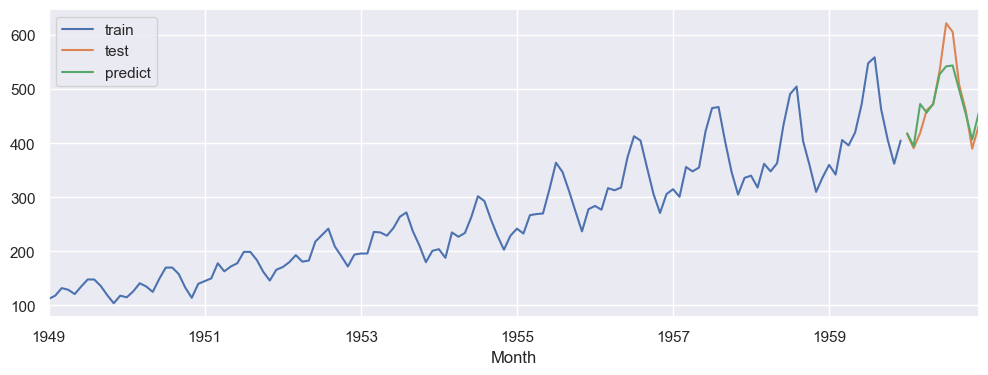

In [77]:
# 予測
y_pred = model.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=["#Passengers"])

fig, ax = plt.subplots(figsize=(12, 4))
y_train.plot(y="#Passengers", ax=ax, label="train")
y_test.plot(y="#Passengers", ax=ax, label="test")
y_pred.plot(y="#Passengers", ax=ax, label="predict")
ax.legend()
plt.show()

## 3. XGBoostを用いた一連の処理フロー

1. CV (クロスバリデーション)・HPO (ハイパーパラメータ最適化)
1. 学習
1. 予測

### 3.1. CV・HPO

In [79]:
# CV spliter.
cv = GroupTimeSeriesSplit(n_splits=5)

# CVを介したハイパーパラメータ探索インスタンス.
search = XGBoostOptunaSearchCV(
    n_estimators=1000,
    early_stopping_rounds=50,
    cv=cv,
)

# 最適化
search.fit(
    X=X_train,
    y=y_train,
    groups=X_train.index,
    n_trials=30,
    show_progress_bar=True,
    eval_verbosity=0,
    optuna_verbosity=0
)

/Users/yuta.sonoda/opt/anaconda3/envs/analytics-sandbox/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/30 [00:00<?, ?it/s]

XGBoostOptunaSearchCV(cv=GroupTimeSeriesSplit(max_train_size=None, n_splits=5, sort_groups=True),
                      early_stopping_rounds=50,
                      sampler=<optuna.samplers._tpe.sampler.TPESampler object at 0x7f982aca0a00>)

In [80]:
# Optunaによって求められたハイパーパラメータ.
best_params = search.study.best_trial.params
best_params["n_estimators"] = 1000

best_params

{'reg_lambda': 1.326404760107769,
 'reg_alpha': 0.004623945156842208,
 'gamma': 8,
 'colsample_bytree': 0.9,
 'subsample': 0.8,
 'learning_rate': 0.016,
 'max_depth': 13,
 'min_child_weight': 1,
 'n_estimators': 1000}

### 3.2. 学習

In [81]:
model_opt = XGBoostRegressor(**best_params)
model_opt.fit(X_train, y_train)

XGBoostRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                 colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
                 early_stopping_rounds=None, enable_categorical=False,
                 eval_metric=None, gamma=8, gpu_id=-1, grow_policy='depthwise',
                 importance_type=None, interaction_constraints='',
                 learning_rate=0.016, max_bin=256, max_cat_to_onehot=4,
                 max_delta_step=0, max_depth=13, max_leaves=0,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=1000, n_jobs=0, num_parallel_tree=1,
                 predictor='auto', random_state=0,
                 reg_alpha=0.004623945156842208, reg_lambda=1.326404760107769, ...)

### 3.3. 予測

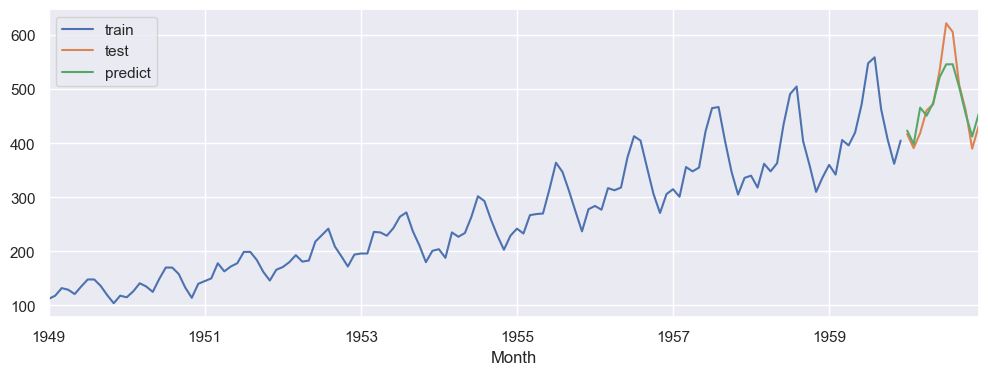

In [82]:
# 予測
y_pred = model_opt.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=["#Passengers"])

fig, ax = plt.subplots(figsize=(12, 4))
y_train.plot(y="#Passengers", ax=ax, label="train")
y_test.plot(y="#Passengers", ax=ax, label="test")
y_pred.plot(y="#Passengers", ax=ax, label="predict")
ax.legend()
plt.show()

In [83]:
mape = mean_absolute_percentage_error(y_test, model.predict(X_test))
mape_opt = mean_absolute_percentage_error(y_test, model_opt.predict(X_test))

print("[Before HPO] MAPE: {}%".format(round(mape*100, 2)))
print("[After  HPO] MAPE: {}%".format(round(mape_opt*100, 2)))

[Before HPO] MAPE: 4.38%
[After  HPO] MAPE: 4.58%


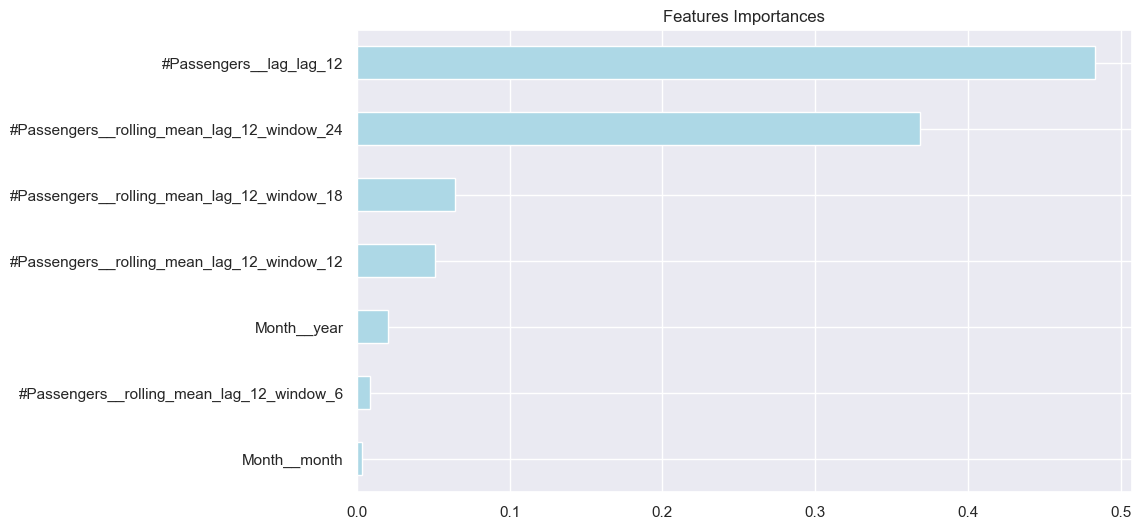

In [87]:
importances = pd.Series(data=model_opt.feature_importances_, index=model_opt.feature_names_in_)
importances_sorted = importances.sort_values()

plt.figure(figsize=(10, 6))
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Features Importances')
plt.show()

In [88]:
# ガーベッジコレクション.
import gc

gc.collect()
gc.collect()

0